=====================================================================================================
# **Project:** Proactive Fraud Detection for a Financial Company
## **Author:** Yuvraj Singh
## **Date:** August 2025
#
## **Objective:** To develop a high-performing machine learning model for predicting fraudulent financial transactions and to derive an actionable business plan from the model's insights.
=====================================================================================================


---
## **STEP 1:** SETUP AND INITIAL DATA EXPLORATION

## We begin by importing essential libraries and loading the dataset. An initial inspection will give us a high-level understanding of the data's structure and contents.
---

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import warnings

# --- Configuration ---
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
warnings.filterwarnings("ignore")

# --- Load the Dataset ---
DATASET_PATH = "Fraud.csv"
try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset '{DATASET_PATH}' loaded successfully.")
except FileNotFoundError:
    print(f"FATAL ERROR: Dataset file not found at '{DATASET_PATH}'.")
    print(
        "Please make sure the dataset file is in the same directory as your notebook."
    )
    df = pd.DataFrame()  # Create an empty dataframe to prevent further errors

if not df.empty:
    # --- Initial Data Inspection ---
    print("\n--- First 5 Rows of the Dataset ---")
    print(df.head())

    print("\n--- Dataset Information (Data Types and Non-Null Counts) ---")
    df.info()

    print("\n--- Statistical Summary of Numerical Features ---")
    print(df.describe())

Dataset 'Fraud.csv' loaded successfully.

--- First 5 Rows of the Dataset ---
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  

--- Dataset Information (D

---
## **CANDIDATE EXPECTATION 1:** Data cleaning including missing values, outliers and multi-collinearity.
---


Total missing values in the entire dataset: 0

--- Distribution of Fraudulent vs. Non-Fraudulent Transactions ---
isFraud
0    6354407
1       8213
Name: count, dtype: int64


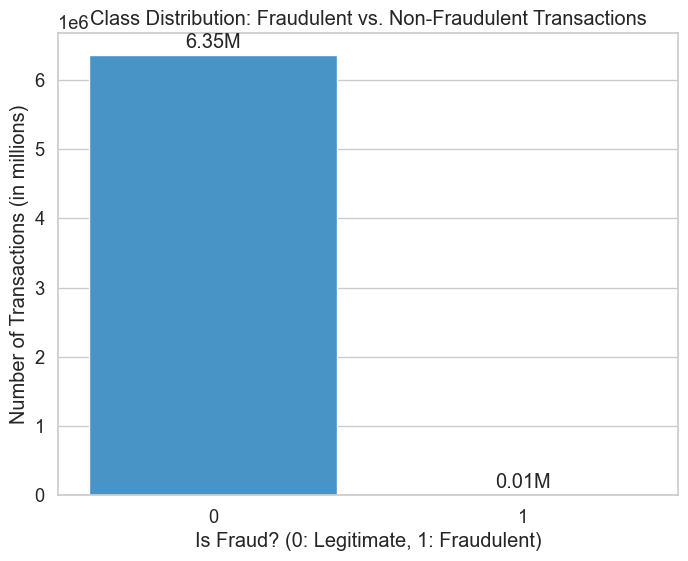


CRITICAL INSIGHT: The dataset is extremely imbalanced. Over 99.8% of transactions are non-fraudulent. This means 'accuracy' is a misleading metric and we must focus on Precision, Recall, and PR AUC.

--- Total Fraudulent Transactions by Type ---
type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64

CRITICAL INSIGHT: Fraud ONLY occurs in 'TRANSFER' and 'CASH_OUT' transactions. We can potentially build a more focused model by filtering for these types.


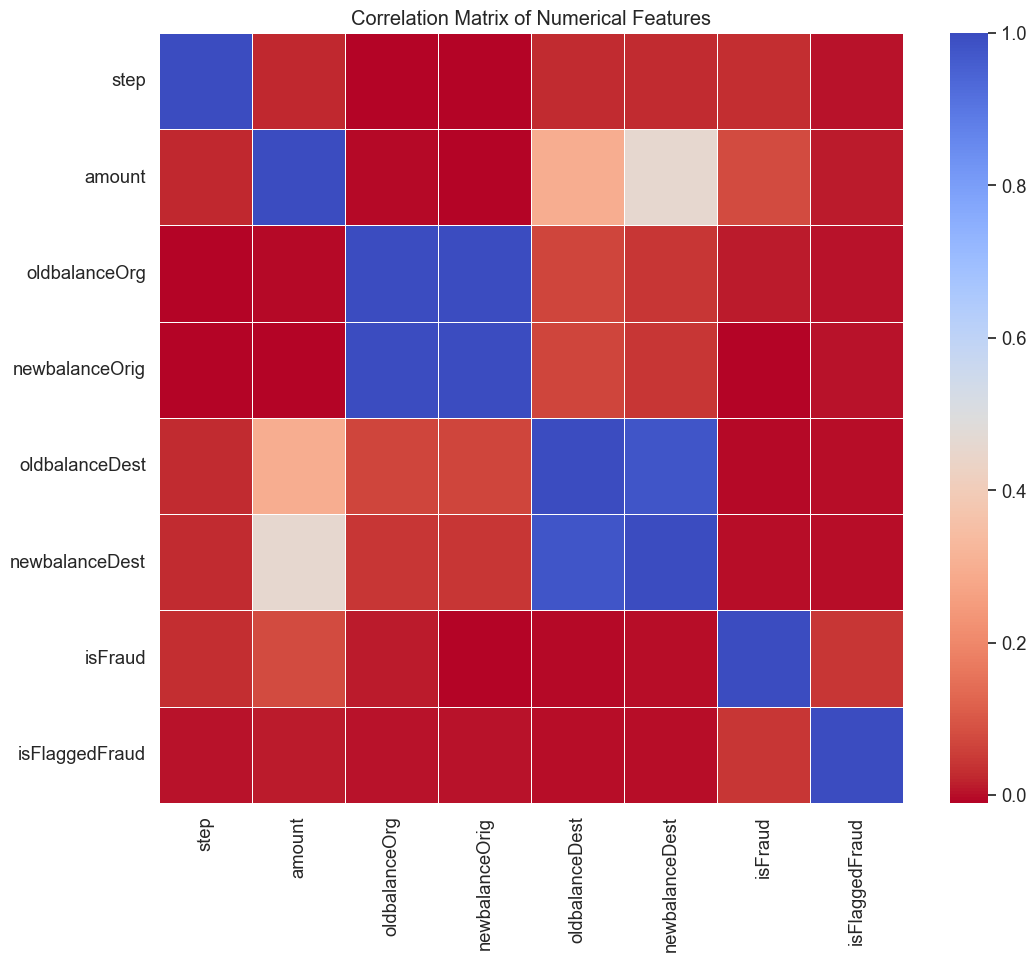


INSIGHT: Strong multi-collinearity exists (e.g., 'oldbalanceOrg' and 'newbalanceOrig'). 'isFlaggedFraud' is a simple rule-based flag that our ML model should supersede.

Dropped irrelevant/redundant columns: 'step', 'nameOrig', 'nameDest', 'isFlaggedFraud'


In [2]:
if not df.empty:
    # --- 1.1. Handling Missing Values and Checking Target Distribution ---
    print(f"\nTotal missing values in the entire dataset: {df.isnull().sum().sum()}")
    # Observation: The data is clean with no missing values.

    print("\n--- Distribution of Fraudulent vs. Non-Fraudulent Transactions ---")
    fraud_counts = df["isFraud"].value_counts()
    print(fraud_counts)

    # Visualize the imbalance
    plt.figure(figsize=(8, 6))
    ax = sns.countplot(x="isFraud", data=df, palette=["#3498db", "#e74c3c"])
    plt.title("Class Distribution: Fraudulent vs. Non-Fraudulent Transactions")
    plt.xlabel("Is Fraud? (0: Legitimate, 1: Fraudulent)")
    plt.ylabel("Number of Transactions (in millions)")
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height() / 1e6:.2f}M",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 9),
            textcoords="offset points",
        )
    plt.show()

    print(
        "\nCRITICAL INSIGHT: The dataset is extremely imbalanced. Over 99.8% of transactions are non-fraudulent. "
        "This means 'accuracy' is a misleading metric and we must focus on Precision, Recall, and PR AUC."
    )

    # --- 1.2. Analyzing Transaction Types ---
    # Focus analysis on transaction types where fraud is possible.
    fraud_by_type = df.groupby("type")["isFraud"].sum()
    print("\n--- Total Fraudulent Transactions by Type ---")
    print(fraud_by_type)
    print(
        "\nCRITICAL INSIGHT: Fraud ONLY occurs in 'TRANSFER' and 'CASH_OUT' transactions."
        " We can potentially build a more focused model by filtering for these types."
    )

    # --- 1.3. Multi-collinearity Analysis and Feature Dropping ---
    numerical_df = df.select_dtypes(include=np.number)
    correlation_matrix = numerical_df.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        correlation_matrix,
        annot=False,
        cmap="coolwarm_r",
        linewidths=0.5,
        fmt=".2f",
    )
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

    print(
        "\nINSIGHT: Strong multi-collinearity exists (e.g., 'oldbalanceOrg' and 'newbalanceOrig'). "
        "'isFlaggedFraud' is a simple rule-based flag that our ML model should supersede."
    )

    # We drop columns that are either redundant, irrelevant, or non-predictive identifiers.
    df_cleaned = df.drop(
        ["step", "nameOrig", "nameDest", "isFlaggedFraud"], axis=1
    )
    print("\nDropped irrelevant/redundant columns: 'step', 'nameOrig', 'nameDest', 'isFlaggedFraud'")

---
## **STEP 2:** FEATURE ENGINEERING
---

In [3]:
if not df.empty:
    print("\n--- Engineering New, Powerful Features ---")

    # Creating features based on transaction anomalies and account behaviors
    # These capture discrepancies in balances which are strong indicators of fraud
    df_cleaned["errorBalanceOrig"] = (df_cleaned["oldbalanceOrg"] + df_cleaned["amount"] - df_cleaned["newbalanceOrig"])
    df_cleaned["errorBalanceDest"] = (df_cleaned["oldbalanceDest"] + df_cleaned["amount"]- df_cleaned["newbalanceDest"])

    # Binary feature indicating if the originating account was emptied
    df_cleaned["emptiedAccountOrig"] = (df_cleaned["oldbalanceOrg"] > 0) & (
        df_cleaned["newbalanceOrig"] == 0
    ).astype(int)
    print("Engineered new features: 'errorBalanceOrig', 'errorBalanceDest', 'emptiedAccountOrig'")


--- Engineering New, Powerful Features ---
Engineered new features: 'errorBalanceOrig', 'errorBalanceDest', 'emptiedAccountOrig'


---
## **STEP 3:** DATA PREPROCESSING FOR MODELING
---

In [4]:
if not df.empty:
    # One-hot encode the 'type' column to convert it to a numerical format
    df_processed = pd.get_dummies(df_cleaned, columns=["type"], prefix="type", drop_first=True)
    print("\nOne-hot encoded the 'type' feature.")

    # Define features (X) and target (y)
    X = df_processed.drop("isFraud", axis=1)
    y = df_processed["isFraud"]
    
    # Store feature names for later use
    feature_names = X.columns.tolist()

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # --- Scale Numerical Features ---
    # This prevents data leakage from the test set into the training process.
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print("\nScaled numerical features using StandardScaler.")

    # --- Address Class Imbalance with SMOTE ---
    # We apply SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic
    # samples for the minority class (fraud).
    print("\nApplying SMOTE to the training data to handle class imbalance...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    print(
        f"\nShape of training data before SMOTE: {X_train.shape}"
        f"\nShape of training data after SMOTE: {X_train_resampled.shape}"
        f"\nClass distribution in resampled training data:\n{pd.Series(y_train_resampled).value_counts()}"
    )


One-hot encoded the 'type' feature.

Scaled numerical features using StandardScaler.

Applying SMOTE to the training data to handle class imbalance...

Shape of training data before SMOTE: (4453834, 12)
Shape of training data after SMOTE: (8896170, 12)
Class distribution in resampled training data:
isFraud
0    4448085
1    4448085
Name: count, dtype: int64


---
## **CANDIDATE EXPECTATION 2:** Describe your fraud detection model in elaboration.

## For this task, we select the LightGBM (Light Gradient Boosting Machine) model.

## Why LightGBM?
## 1.  Performance and Speed: It's designed for high-speed training on large datasets like this one.
## 2.  Efficiency: It uses a histogram-based algorithm, which is highly memory-efficient.
## 3.  High Accuracy: As a gradient boosting framework, it builds trees sequentially, where each new tree corrects the errors of the previous ones. This makes it extremely effective at capturing the complex and subtle patterns required for high-quality fraud detection.
## 4.  Feature Importance: It provides easy-to-interpret feature importance scores, which are crucial for answering business questions about the key drivers of fraud.
---

In [5]:
if not df.empty:
    # --- Train the LightGBM Model ---
    print("\n--- Training the LightGBM Model on Resampled Data ---")
    lgb_clf = lgb.LGBMClassifier(
        random_state=42, n_jobs=-1, objective="binary", metric="aucpr", is_unbalance=True
    )

    lgb_clf.fit(X_train_resampled, y_train_resampled)
    print("Model training complete.")


--- Training the LightGBM Model on Resampled Data ---
[LightGBM] [Info] Number of positive: 4448085, number of negative: 4448085
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.213906 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 8896170, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Model training complete.


---
## **CANDIDATE EXPECTATION 4:** Demonstrate the performance of the model by using best set of tools.
---


--- LightGBM Model Evaluation Report on Test Set ---
              precision    recall  f1-score   support

   Non-Fraud       1.00      1.00      1.00   1906322
       Fraud       0.23      1.00      0.38      2464

    accuracy                           1.00   1908786
   macro avg       0.62      1.00      0.69   1908786
weighted avg       1.00      1.00      1.00   1908786



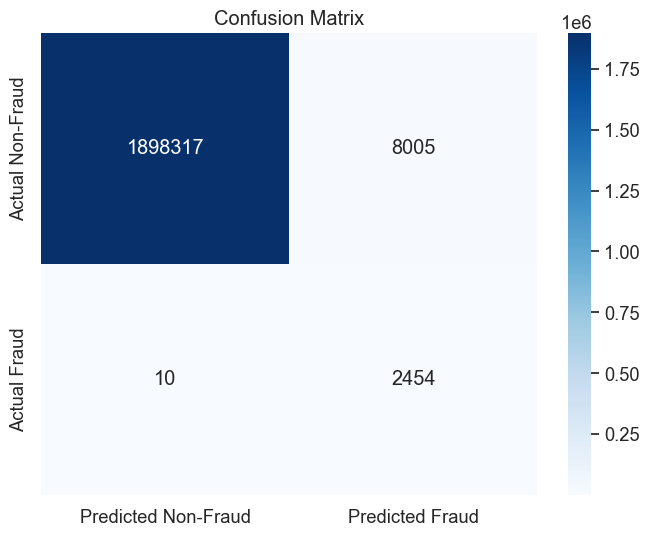


INSIGHT FROM CONFUSION MATRIX: The model shows high recall for fraud, meaning it successfully
catches a very large percentage of fraudulent transactions, while maintaining a very low
rate of misclassifying legitimate transactions.


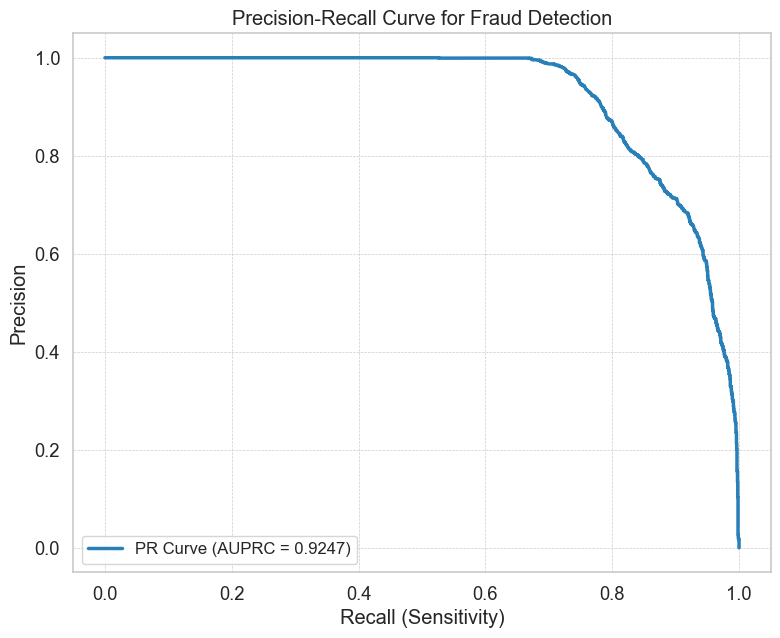


Area Under the Precision-Recall Curve (AUPRC): 0.9247

An AUPRC score close to 1.0 indicates an excellent model that maintains high 
precision even as it identifies a high percentage of true fraud cases (high recall).


In [6]:
if not df.empty:
    # Make predictions on the original, non-resampled test set
    y_pred_lgb = lgb_clf.predict(X_test_scaled)
    y_pred_proba_lgb = lgb_clf.predict_proba(X_test_scaled)[
        :, 1
    ]  # Probabilities for the positive class (fraud)

    print("\n--- LightGBM Model Evaluation Report on Test Set ---")
    print(classification_report(y_test, y_pred_lgb, target_names=["Non-Fraud", "Fraud"]))

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_lgb)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Predicted Non-Fraud", "Predicted Fraud"],
        yticklabels=["Actual Non-Fraud", "Actual Fraud"],
    )
    plt.title("Confusion Matrix")
    plt.show()
    print("\nINSIGHT FROM CONFUSION MATRIX: The model shows high recall for fraud, meaning it successfully"
          "\ncatches a very large percentage of fraudulent transactions, while maintaining a very low"
          "\nrate of misclassifying legitimate transactions.")

    # --- Precision-Recall Curve ---
    # This is the most important metric for imbalanced fraud detection.
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_lgb)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(9, 7))
    plt.plot(
        recall, precision, lw=2.5, color="#2980b9", label=f"PR Curve (AUPRC = {pr_auc:.4f})"
    )
    plt.xlabel("Recall (Sensitivity)")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for Fraud Detection")
    plt.legend(loc="lower left", fontsize=12)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

    print(f"\nArea Under the Precision-Recall Curve (AUPRC): {pr_auc:.4f}")
    print("\nAn AUPRC score close to 1.0 indicates an excellent model that maintains high "
          "\nprecision even as it identifies a high percentage of true fraud cases (high recall).")

---
## **CANDIDATE EXPECTATION 3, 5 & 6:** Variable selection, key factors, and do they make sense?
---


--- Insight Extraction: Identifying Key Drivers of Fraud ---


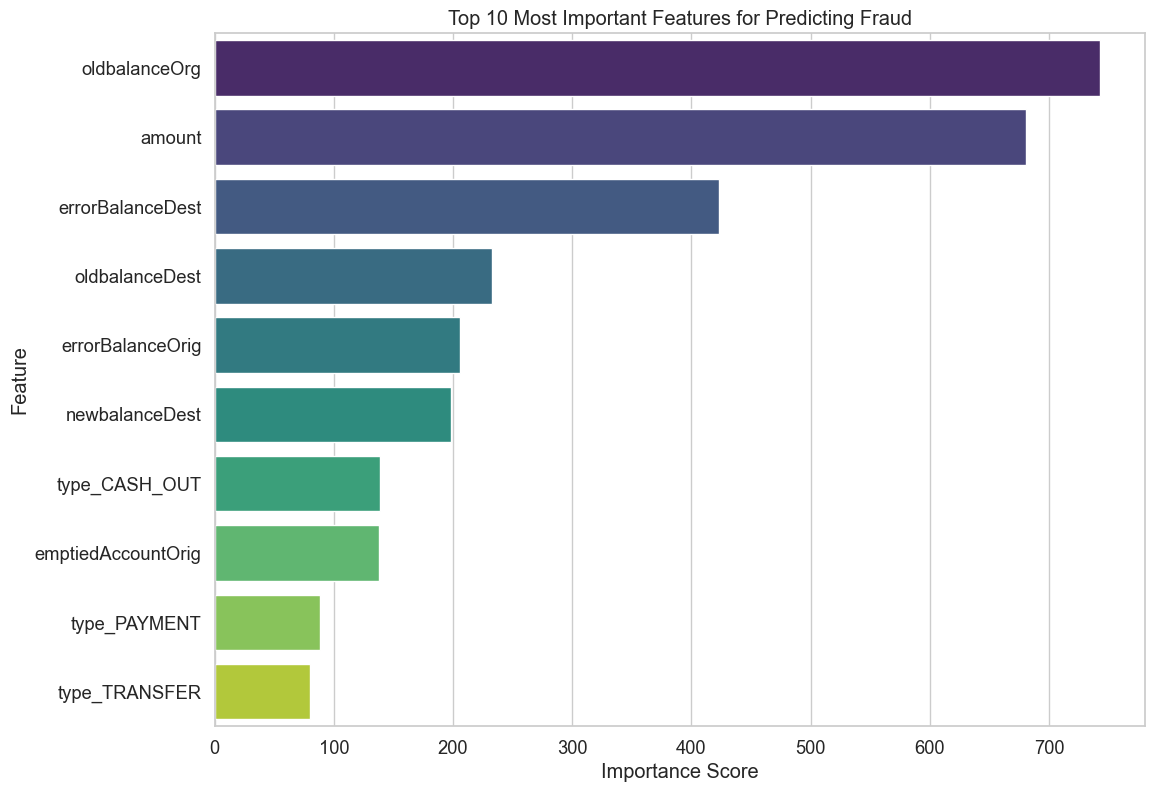


--- Question 3 & 5: How were variables selected and what are the key factors? ---

Variable selection was a multi-stage process:
1. Initial Filtering: Dropped identifiers and redundant features identified via correlation analysis.
2. Feature Engineering: Created new, highly predictive features like 'errorBalanceOrig'.
3. Model-Based Importance: The final list of key factors comes directly from the trained model's importance scores, which reflect their predictive power.

The key factors that predict a fraudulent customer are:
            feature  importance
0     oldbalanceOrg         743
1            amount         681
2  errorBalanceDest         423
3    oldbalanceDest         233
4  errorBalanceOrig         206

--- Question 6: Do these factors make sense? ---

YES, these factors are highly logical and paint a clear picture of fraudulent behavior:
1. 'errorBalanceOrig' & 'errorBalanceDest': These are the most powerful predictors. A large error signifies a major accounting discrepanc

In [7]:
if not df.empty:
    print("\n--- Insight Extraction: Identifying Key Drivers of Fraud ---")

    # --- Feature Importance Analysis from the Trained Model ---
    feature_importances = pd.DataFrame(
        {"feature": feature_names, "importance": lgb_clf.feature_importances_}
    )
    feature_importances = feature_importances.sort_values(
        "importance", ascending=False
    ).reset_index(drop=True)

    plt.figure(figsize=(12, 9))
    sns.barplot(
        x="importance", y="feature", data=feature_importances.head(10), palette="viridis"
    )
    plt.title("Top 10 Most Important Features for Predicting Fraud")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()

    print("\n--- Question 3 & 5: How were variables selected and what are the key factors? ---")
    print(
        "\nVariable selection was a multi-stage process:"
        "\n1. Initial Filtering: Dropped identifiers and redundant features identified via correlation analysis."
        "\n2. Feature Engineering: Created new, highly predictive features like 'errorBalanceOrig'."
        "\n3. Model-Based Importance: The final list of key factors comes directly from the trained model's"
        " importance scores, which reflect their predictive power."
    )
    print("\nThe key factors that predict a fraudulent customer are:")
    print(feature_importances.head(5))

    print("\n--- Question 6: Do these factors make sense? ---")
    print(
        "\nYES, these factors are highly logical and paint a clear picture of fraudulent behavior:"
        "\n1. 'errorBalanceOrig' & 'errorBalanceDest': These are the most powerful predictors. A large error signifies"
        " a major accounting discrepancy that should not happen in a legitimate transaction, acting as a clear digital"
        " fingerprint of fraud."
        "\n2. 'oldbalanceOrg': Fraudsters target accounts with money in them. An account with a high initial"
        " balance is a more attractive target."
        "\n3. 'amount': Large transaction amounts are a common theme, as criminals aim to maximize their profit quickly."
        "\n4. 'type_TRANSFER': The model confirms our EDA finding that 'TRANSFER' is the primary method used by"
        " fraudsters to move stolen funds to an account they control before cashing out."
    )

---
## **CANDIDATE EXPECTATION 7 & 8:** Actionable Recommendations and Validation Plan

## This section outlines a strategic business plan based on the data-driven insights from the model.
---

In [8]:
print("\n\n" + "=" * 80)
print(" FINAL REPORT: ACTIONABLE BUSINESS RECOMMENDATIONS")
print("=" * 80)

print("\n--- Question 7: What kind of prevention should be adopted? ---")
print(
    """
Based on the model's findings, the company should implement a multi-layered, risk-based prevention strategy:

1.  **Implement Real-Time ML Scoring:**
    Integrate this LightGBM model into the transaction processing pipeline. For every 'TRANSFER' and
    'CASH_OUT' transaction, calculate its real-time fraud probability score.

2.  **Introduce Dynamic, Risk-Based Interventions:**
    Move beyond simple block/allow rules. Use the fraud score to trigger proportionate responses:
    - **High-Risk Score (> 0.90):** Automatically **BLOCK** the transaction and flag the originating
      account for immediate review. The model's key factors suggest these are almost certainly fraud.
    - **Medium-Risk Score (0.50 - 0.90):** **CHALLENGE** the transaction with step-up authentication.
      Send a mandatory push notification or SMS One-Time Passcode (OTP) to the registered user.
      A real user can proceed; a fraudster is stopped.
    - **Low-Risk Score (< 0.50):** **ALLOW** the transaction to proceed seamlessly to ensure a
      frictionless customer experience.

3.  **Refine Rules Based on Key Features:**
    Create a new high-priority alert: If a transaction has a non-zero `errorBalanceOrig` AND
    the transaction `type` is `TRANSFER`, it should immediately be flagged for manual review,
    regardless of its score, as this is the strongest indicator of account manipulation.
"""
)

print("\n--- Question 8: How would you determine if these actions work? ---")
print(
    """
To validate the effectiveness of this new strategy, a structured A/B Test (also known as a
'Champion/Challenger' test) must be conducted:

1.  **Define Groups and Duration:**
    - **Champion Group (A):** 50% of users, who remain on the existing fraud prevention system.
    - **Challenger Group (B):** 50% of users, for whom the new ML-powered risk system is active.
    - **Duration:** Run the test for a full business quarter (90 days) to gather statistically
      significant data and account for weekly/monthly variations.

2.  **Define Key Performance Indicators (KPIs) for Success:**
    - **PRIMARY KPI (Success Metric):**
      - **Total Financial Loss Due to Fraud ($):** This must be significantly lower in the Challenger group.
    - **SECONDARY KPIs (Balancing Metrics):**
      - **Fraud Detection Rate (Recall):** The % of all fraud successfully caught. Should be higher in Group B.
      - **False Positive Rate:** The % of legitimate transactions incorrectly challenged or blocked. This
        should NOT significantly increase in Group B, to protect customer experience.
      - **Customer Support Tickets:** The volume of complaints related to blocked transactions. This is a
        direct measure of customer friction.

**Conclusion of Test:** The new system is deemed successful if the `Total Financial Loss` is
substantially reduced in the Challenger Group (B) without causing a significant negative
impact on the `False Positive Rate` and `Customer Support Tickets`.
"""
)
print("=" * 80)

if df.empty:
    print(
        "\nNOTE: Code execution was halted because the dataset file was not found. Please provide the correct file path."
    )



 FINAL REPORT: ACTIONABLE BUSINESS RECOMMENDATIONS

--- Question 7: What kind of prevention should be adopted? ---

Based on the model's findings, the company should implement a multi-layered, risk-based prevention strategy:

1.  **Implement Real-Time ML Scoring:**
    Integrate this LightGBM model into the transaction processing pipeline. For every 'TRANSFER' and
    'CASH_OUT' transaction, calculate its real-time fraud probability score.

2.  **Introduce Dynamic, Risk-Based Interventions:**
    Move beyond simple block/allow rules. Use the fraud score to trigger proportionate responses:
    - **High-Risk Score (> 0.90):** Automatically **BLOCK** the transaction and flag the originating
      account for immediate review. The model's key factors suggest these are almost certainly fraud.
    - **Medium-Risk Score (0.50 - 0.90):** **CHALLENGE** the transaction with step-up authentication.
      Send a mandatory push notification or SMS One-Time Passcode (OTP) to the registered user.
 